In [1]:
from pathlib import Path
import sys
sys.path.append('../')
from pma_open import *


#My image
file_path = '../Dropbox Files/hel1.pma'
image_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame.png"
image = io.imread(image_path, as_gray=True)

#Chanel image paths
CH1_img_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame_CH1.png"
CH2_img_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame_CH2.png"

good_peaks_1,_ = good_peak_finder(CH1_img_path)
good_peaks_2_new,_ = good_peak_finder(CH2_img_path, sigma=2, block_size=16, scaler_percent=10, boarder=10, max_rad=3)

# Move good_peaks_1 to CH2 to display full image
good_peaks_1_CH2 = shift_peaks(good_peaks_1)
good_peaks_2_CH2 = shift_peaks(good_peaks_2_new)

# Poly Mapping
CH1_peaks_10= np.array([[14, 190], [308, 10], [493, 131], [115, 168], [273, 61], [55, 59], [179, 41], [234, 157], [365, 161], [502, 43]])
CH2_peaks_10 = np.array([[18, 449], [311, 269], [492, 388], [119, 427], [276, 319], [60, 318], [183, 300], [236, 416], [364, 419], [501, 301]])

params_x_man_10, params_y_man_10 = find_polyfit_params(CH1_peaks_10, CH2_peaks_10, degree=3)
mapped_peaks_10 = apply_polyfit_params(good_peaks_1, params_x_man_10, params_y_man_10).astype(np.uint16)
poly_pair_count_tol4_10, poly_pair_arr_CH1_tol4_10, poly_pair_arr_CH2_tol4_10 = find_polyfit_pairs(mapped_peaks_10, good_peaks_1, tolerance=4)

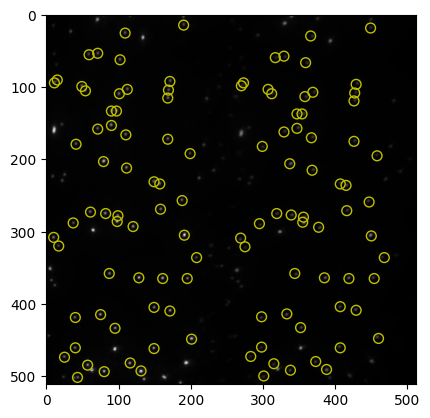

In [2]:
fig, ax = plt.subplots()
plt.imshow(image, cmap='gray')
ax.scatter(poly_pair_arr_CH1_tol4_10[:,1], poly_pair_arr_CH1_tol4_10[:,0], facecolors='none', edgecolors='y', s=50, label='CH1')
ax.scatter(poly_pair_arr_CH2_tol4_10[:,1], poly_pair_arr_CH2_tol4_10[:,0], facecolors='none', edgecolors='y', s=50, label='CH2')
plt.show()

# Calculate Static Global Background. 
#### Static-> Based on the average frame data only
#### Global -> uniform across the frame

In [3]:
circle_array_CH1 = draw_circle(4, poly_pair_arr_CH1_tol4_10[:,1], poly_pair_arr_CH1_tol4_10[:,0], image.shape[0])
circle_array_CH2 = draw_circle(4, poly_pair_arr_CH2_tol4_10[:,1], poly_pair_arr_CH2_tol4_10[:,0], image.shape[0])
circle_array_new = circle_array_CH1 + circle_array_CH2

mask_new = (circle_array_new == [255, 255, 0]).all(axis=-1)
if image.ndim == 2:
    image_3d = np.repeat(image[..., np.newaxis], 3, -1)
elif image.ndim==3 and image.shape[2]==3:
    image_3d = image
image_3d[mask_new] = [255, 255, 0]

In [4]:
#in stage 0 we are making sure we are getting the total of all peaks
def static_global_background_0(input_array, radius, y_centre_arr, x_centre_arr):
    all_peaks_intensity = 0
    pixel_count = 0
    #filling in the circle
    for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
        for i in range(x_centre - radius, x_centre+ radius + 1):
            for j in range(y_centre - radius, y_centre + radius + 1):
                if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
                    all_peaks_intensity += int(input_array[i][j][0])
                    pixel_count += 1
        

    return all_peaks_intensity, pixel_count

In [5]:
total_peak_intensity, pixel_count = static_global_background_0(image_3d, 4, np.concatenate((poly_pair_arr_CH1_tol4_10[:,0],poly_pair_arr_CH2_tol4_10[:,0])), np.concatenate((poly_pair_arr_CH1_tol4_10[:,1],poly_pair_arr_CH2_tol4_10[:,1])))
print(total_peak_intensity)
print(pixel_count)

65887
5040


# Testing this with our fake peaks!

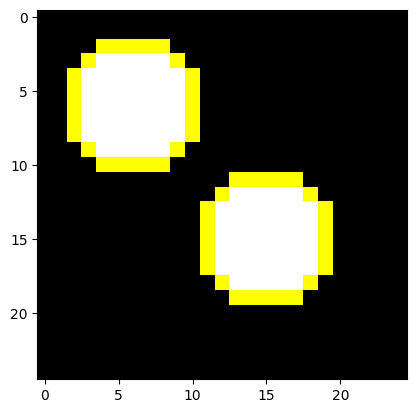

In [6]:
#Demonstates that we are selecting the pixels within the yellow circle outline
def fill_circle(input_array, radius, y_centre_arr, x_centre_arr, colour_fill = [255, 255, 255]):
    #setting background to [0,0,0]
    #filling in the circle
    for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
        for i in range(x_centre - radius, x_centre + radius + 1):
            for j in range(y_centre - radius, y_centre + radius + 1):
                if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
                    input_array[i, j] = colour_fill
    
    return input_array
radius = 4
background_dim= 25
x_cen = np.array([6, 15])
y_cen = np.array([6, 15])
background_array = draw_circle(radius, y_cen, x_cen, background_dim)
circle_array = fill_circle(background_array, radius, y_cen, x_cen)
plt.imshow(circle_array)

In [7]:
total_peak_intensity_circle, pixel_count_circle = static_global_background_0(circle_array, 4, y_cen, x_cen)
print(f"Total peak intensity: {total_peak_intensity_circle}")
print(45*2*255)
print(f"Total arr: {pixel_count_circle}")
print(45*2)

Total peak intensity: 22950
22950
Total arr: 90
90


# This code works so far so we should continue!
#### Add up the entire pixel intensity of the frame
#### Take away the total pixel intensity of the peaks
#### divide by the number of total pixels 512*512
#### this is the number we should take away from every pixel value!

In [8]:
#in stage 1 we should be getting the total value of all pixels in the image (DO NOT USE image_3d)

def static_global_background_1(input_array_w_circle, input_array_no_circle, radius, y_centre_arr, x_centre_arr):
    all_peaks_intensity = 0
    pixel_count = 0
    #filling in the circle
    for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
        for i in range(x_centre - radius, x_centre+ radius + 1):
            for j in range(y_centre - radius, y_centre + radius + 1):
                if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
                    all_peaks_intensity += int(input_array_w_circle[i][j][0])
                    pixel_count += 1
    
    #find the total intensity of all pixels in the background_array
    total_intensity = 0
    for i in range(input_array_no_circle.shape[0]):
        for j in range(input_array_no_circle.shape[1]):
            total_intensity += int(input_array_no_circle[i][j][0])

    return all_peaks_intensity, pixel_count, total_intensity

Total peak intensity: 22950
45*2*255: 22950
Pixel_count_circle1: 90
Total pixel intensity: 35190


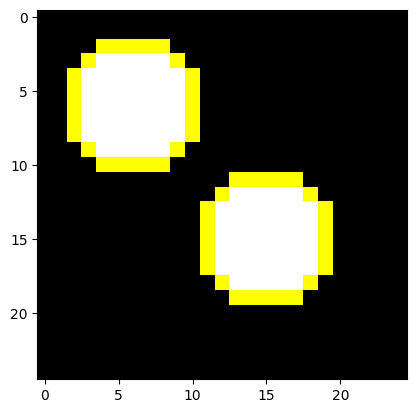

In [9]:
plt.imshow(background_array)
total_peak_intensity_circle1, pixel_count_circle1, total_intensity_circle1= static_global_background_1(background_array, background_array, 4, y_cen, x_cen)
print(f"Total peak intensity: {total_peak_intensity_circle1}")
print(f"45*2*255: {45*2*255}")
print(f"Pixel_count_circle1: {pixel_count_circle1}")
print(F"Total pixel intensity: {total_intensity_circle1}")


In [10]:
num_pix = count_circle(radius=4)
print(type(num_pix))
print(num_pix)

<class 'int'>
45


In [11]:
#At the final stage we should be subtracting total pixel intensity from peak pixel intensity and dividing by the number of pixels in the frame
#then return the number that we get out
def static_global_background(input_array, radius, y_centre_arr, x_centre_arr):
    all_peaks_intensity = 0
    pixel_count = 0
    #filling in the circle
    for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
        for i in range(x_centre - radius, x_centre+ radius + 1):
            for j in range(y_centre - radius, y_centre + radius + 1):
                if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
                    all_peaks_intensity += int(input_array[i][j][0])
                    pixel_count += 1
    
    # by summing the third column of the array we exclude the yellow pixels from being included!
    total_intensity = np.sum(input_array[:, :,2])

    
    num_of_peaks = len(y_centre_arr)
    num_of_peak_pixels = count_circle(radius) * num_of_peaks
    num_of_frame_pixels = input_array.shape[0] * input_array.shape[1]

    #avg_peak_intensity gives the avg intensity of the pixels that are not within the yellow circle
    avg_peak_intensity = (total_intensity-all_peaks_intensity) // (num_of_frame_pixels-num_of_peak_pixels)

    return avg_peak_intensity, total_intensity, num_of_peak_pixels

Here we expect 0 since the background is all black
Avg peak intensity: 0

Total pixel intensity: 22950, expected = 22950
Num of peak pixels: 90, expected=90


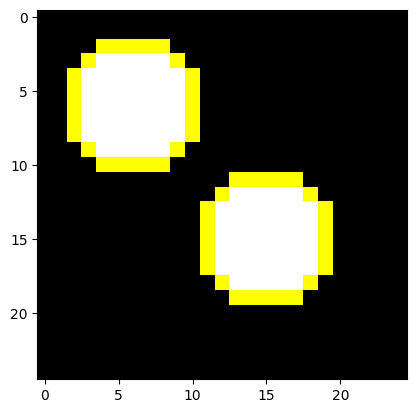

In [12]:
plt.imshow(background_array)
avg_peak_intensity2, total_intensity2, num_of_peak_pixels2= static_global_background(background_array, 4, y_cen, x_cen)

print(f"Here we expect 0 since the background is all black")
print(f"Avg peak intensity: {avg_peak_intensity2}")
print(f"\nTotal pixel intensity: {total_intensity2}, expected = {45*2*255}")
print(f"Num of peak pixels: {num_of_peak_pixels2}, expected={45*2}")

#### The above is a great sign ! we are correctly calculating the total pixel intensity as equal to the predicted value 
# Therefore we can start using this on image_3d

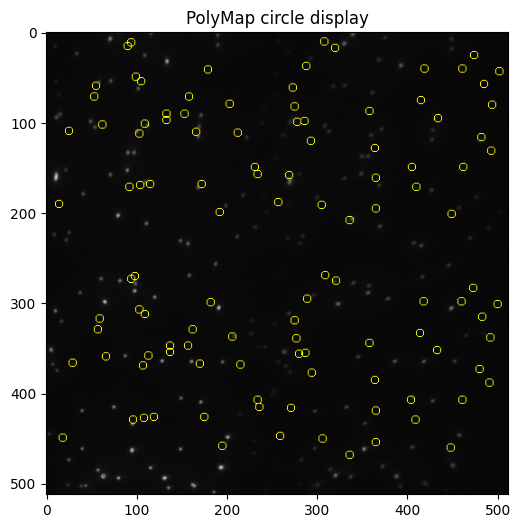

In [13]:
#Should show image_3d so that we know what we are working with.
fig = plt.figure(figsize=(6,6))
ax = fig.subplots()
plt.imshow(image_3d)
plt.title('PolyMap circle display')
plt.show()

In [14]:
y_centres_hel1 = np.concatenate((poly_pair_arr_CH1_tol4_10[:,0],poly_pair_arr_CH2_tol4_10[:,0]))
x_centres_hel1 = np.concatenate((poly_pair_arr_CH1_tol4_10[:,1],poly_pair_arr_CH2_tol4_10[:,1]))
avg_peak_intensity, total_intensity, num_of_peak_pixels= static_global_background(image_3d, 4, y_centres_hel1, x_centres_hel1)
print(f"Avg peak intensity: {avg_peak_intensity}")
print(f"Total pixel intensity: {total_intensity}")
print(f"Num of peak pixels: {num_of_peak_pixels},  expected = {len(y_centres_hel1)*45}")
print(f"\nNumber of peaks: {len(y_centres_hel1)},")
print(f"{len(y_centres_hel1)} * 45: {len(y_centres_hel1)*45}")

Avg peak intensity: 9
Total pixel intensity: 2525112
Num of peak pixels: 5040,  expected = 5040

Number of peaks: 112,
112 * 45: 5040


# Since this Static Global function is working well, we should edit it and then put it in pma_open.py

In [27]:
# final function:
# At the final stage we should be subtracting total pixel intensity from peak pixel intensity and dividing by the number of pixels in the frame
# then return the number that we get out

# def static_global_background_subtraction(pma_file_path, input_array, radius, y_centre_arr, x_centre_arr):
#     frames_data = read_pma(pma_file_path) 
#     all_peaks_intensity = 0
#     pixel_count = 0
#     #filling in the circle
#     for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
#         for i in range(x_centre - radius, x_centre+ radius + 1):
#             for j in range(y_centre - radius, y_centre + radius + 1):
#                 if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
#                     all_peaks_intensity += int(input_array[i][j][0])
#                     pixel_count += 1
    
#     # by summing the third column of the array we exclude the yellow pixels from being included!
#     total_intensity = np.sum(input_array[:, :,2])

    
#     num_of_peaks = len(y_centre_arr)
#     num_of_peak_pixels = count_circle(radius) * num_of_peaks
#     num_of_frame_pixels = input_array.shape[0] * input_array.shape[1]

#     #avg_peak_intensity gives the avg intensity of the pixels that are not within the yellow circle
#     intensity_to_remove = (total_intensity-all_peaks_intensity) // (num_of_frame_pixels-num_of_peak_pixels)
#     corrected_frames_data = []
#     for frame in frames_data: #frame is 1D
#         frame = np.clip(frame - intensity_to_remove, 0, 255).astype(np.uint8)
#         corrected_frames_data.append(frame)
#     return corrected_frames_data

# As for subtracting the avg_peak_intensity from all pixels in all frames

In [32]:
Frames_data = read_pma(file_path)
print(f"Frames_data type: {type(Frames_data)}")
print(f"Frames_data[0] Shape: {Frames_data[0].shape}")
print(f"Frames_data element type: {type(Frames_data[0][0][0])}\n")

corrected_frames_data = static_global_background_subtraction(file_path, image_3d, 4, y_centres_hel1, x_centres_hel1)
print(f"Corrected Frames_data type: {type(corrected_frames_data)}")
print(f"Corrected Frames_data[0] shape: {corrected_frames_data[0].shape}")
print(f"Corrected Frames_data element type: {type(corrected_frames_data[0][0][0])}")

Image Size: 512 x 512
Frames_data type: <class 'list'>
Frames_data[0] Shape: (512, 512)
Frames_data element type: <class 'numpy.uint8'>

Image Size: 512 x 512
Corrected Frames_data type: <class 'list'>
Corrected Frames_data[0] shape: (512, 512)
Corrected Frames_data element type: <class 'numpy.uint8'>
